### ARGO Jupyter notebook


ARGO drifters / floats / platforms do 2000 meter profile runs every ten days at thousands of locations 
across the world's oceans. From the surfae they telemeter data back (iridium satellite link) and these
data are then available for download. Data products tend to include standard CTD; and other instruments
may be onboard a given platform as well.


This notebook deconstructs ARGO data in relation to other data resources. Here are some of the features:
  - Describes the Coriolis portal: Bounding box + time window --> multiple platform .nc files
  - Download, unpack results, open as a list of xarray datasets
  - Inspect the datasets, determine what data are available, how to access
  - Create a map of the bounding box with ARGO trajectories shown
    - Include OOI Cabled Array location markers as well
  - Variants on plotting salinity and/or temperature with depth


**I avoid the ARGO Python package but of course you are welcome to explore that option.**  


The process here begins with the Coriolis portal/interface to ARGO data. This generates downloadable 
.tgz files (notification by email; typically a few minutes) which unpack into a folder of netcdf 
files. Each netcdf file is for a separate ARGO platform ('drifter') and each platform will have one or
more water column profiles for the time interval indicated. There are also ARGO trajectory files 
not covered herein.


This exploration uses **xarray** datasets extending **pandas**. 
This notebook also includes Linux system calls executed from Python; so taking advantage of 
**sys**, **os**, **shutil** and **ftplib** packages.


#### Links


- [Jupyter notebook editing shortcuts](https://www.dataquest.io/blog/jupyter-notebook-tips-tricks-shortcuts/)
- [The ARGO program site at UCSD](http://www.argo.ucsd.edu/)
  - [UCSD ARGO Informational FAQ](http://www.argo.ucsd.edu/Data_FAQ.html#RorD)
- [Coriolis data portal for ARGO](http://www.argodatamgt.org/Access-to-data/Argo-data-selection)
- [pyARGO](https://github.com/castelao/pyARGO) is a GitHub-based Python package; status unclear
- [Lesson on xarray that works with ARGO data](https://rabernat.github.io/research_computing/xarray.html)

- [Heidi Sosik's Imaging Flow Cytometer (WHOI)](http://ifcb-data.whoi.edu/mvco)
  - [Same, API-specific](http://ifcb-data.whoi.edu/api)
- [BCO-DMO (WHOI)](https://www.bco-dmo.org/data)

In [1]:
# Run

# Preparation steps
# Includes grabbing the kilroy.py file to this directory; so that its methods can be imported
#   kilroy.py is a set of common methods I wrote for this project

import os
from   shutil import copyfile
import sys
from   sys import exit

if not os.path.exists('./kilroy.py'):
    copyfile('../kilroy/kilroy.py', './kilroy.py')
    if not os.path.exists('./kilroy.py'):
        print('oh dear; kilroy.py copy to local seems to have failed...')
        exit()
else:
    print('kilroy.py already present')

import kilroy

print('\nHey Jupyter Notebook fans! Running Python {}...'.format(sys.version_info[0]))
print('\n...and here are the kilroy methods we have available:\n')
print(kilroy.nudir(kilroy), '\n')

# This segment makes sure the argo data directory is present
#   Notice it is not part of the Jupyter notebook repo so as to keep size modest
homedir = '/home/jovyan/'
datadir = 'data/'
argodir = 'argo/'
fulldir = homedir + datadir + argodir

if not os.path.exists(fulldir):
    if not os.path.exists(datadir):
        os.mkdir(homedir + datadir)
        if not os.path.exists(homedir + datadir):
            print('tried and failed to create the data directory')
            exit()
    os.mkdir(fulldir)
    if not os.path.exists(fulldir):
        print('tried and failed to create the argo directory')
        exit()
else:
    print('argo data file directory is present; /home/jovyan/data/argo')

FileNotFoundError: [Errno 2] No such file or directory: '../kilroy/kilroy.py'

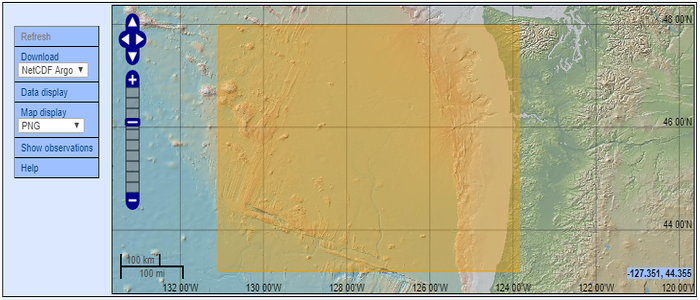

In [3]:
# Optional

# Show the Coriolis interface image
kilroy.ShowLocal('/home/jovyan/data/images/ARGO_BB_selection.png',700,300)

Coriolis (ARGO data selection tool): time interval = 3 months:...


```
We are processing your data request.
The data will be delivered: ftp://ftp.ifremer.fr/ifremer/coriolis/tmp/co0501/DataSelection_20180206_225551_5097076.tgz
```

### Selecting an ARGO dataset 


- As per above go to the [Coriolis web interface to ARGO data](http://www.argodatamgt.org/Access-to-data/Argo-data-selection)
- Use the map interface to select (as above, yellow rectangle) a bounding box. 
- Use the time controls to select start and end times, i.e. a time interval
- Click on Refresh (control left of map), wait for Query to complete
- Click Download; under best circumstances this opens the Data Selection tab in your browser 
  - This click seems a bit inconsistent... it does not always work
  - Alternate plan: After the click: Hover on Download until a long URL shows (bottom of Chrome browser) ...
    - ...right click, Copy link address, paste into a separate window to see the download page
- Enter your email, click the 'Extract your data' button 
- Receive a 'processing' confirmation email directly and a second email in a few minutes with a link to the data


I searched for Jan 1 -- June 30 2016. In a matter of five minutes I received a link by email:


```
ftp://ftp.ifremer.fr/ifremer/coriolis/tmp/co0501/DataSelection_20180221_193406_5147072.tgz
```


This file will expire and vanish in a matter of a few months... so hurry! 
The ftp call (cell below) will return


```
221 Goodbye
```


A feature of the Coriolis interface is that if you change your time interval it will not register.
If you change your *bounding box* then changes in date-range seem to take effect. Best bet is to 
confirm each search returns what you believe you asked for. Probably safest is for each new search
just re-load the site.


Another sidebar: With limited bandwidth (on the Revelle for example) I had my best luck clicking on the 
Download in the interface and then (as it did not open the Download page) grabbing the link and pasting that
into a new browser tab. This is described above. To continue from there: Provide an email address and wait for
the confirmation. Now how to get the data file; which is generally 1 MB or less...


Go to the ftp server base folder (again new browser tab) at 
ftp://ftp.ifremer.fr. From here navigate one click at a time: ifremer, coriolis, tmp, co0401, and there 
at last (once all the filenames load) should be the datafile with filename 
```DataSelection_yyyymmdd_aaaaaaaa_bbbbbbb.tgz```.


Nov 1 2016 through Oct 31 2017 was delivered on July 21, 2018 as


```
 ftp://ftp.ifremer.fr/ifremer/coriolis/tmp/co0501/DataSelection_20180721_005001_6035170.tgz
```


After ftp recovery (which can be automated per the cells below this one)...


- Move the file to the directory ```/home/jovyan/data/argo```
- Unzip the file with ```gunzip <filename.tgz>``` 
- untar the resulting ```.tar``` file with ```tar -xvf filename.tar```
- Re-name the resulting folder which has an ungainly name
  - For example I name it based on the time window, as in ```2016_nov_thru_2017_oct```
  
  
This folder will contain a set of profile data files and trajectory data files, all in netcdf format. 
In what follows we focus on the profile data only. 

In [5]:
# Don't
#
# ftp the dataset (.tgz) file
# This cell assumes that you have staged a .tgz data file via Coriolis (see above)
#   Modify dataIDString to match this staged data and set the bool at the top to True.
#   This code should then retrieve that .tgz file to the local argo directory; but it may clobber
#     any prior results since there is no checking for preexisting. 

# This cell will not run until this bool is flipped
get_data_by_ftp = False


if get_data_by_ftp:
    relpath = '../../../../data/argo/'
    from ftplib import FTP
    dataIDString = '20180721_005001_6035170'
    myIDString = relpath + 'ARGO_Retrieval.tgz'
    ftp = FTP('ftp.ifremer.fr')
    ftp.login()
    ftp.cwd('ifremer/coriolis/tmp/co0501/')
    ftp.retrlines('LIST DataSelection_' + dataIDString + '.tgz')
    ftp.retrbinary('RETR DataSelection_' + dataIDString + '.tgz', open(myIDString, 'wb').write)
    ftp.quit()

    # Create a list of .tgz files to unpack
    tgzList = []
    relpath = '../../../../data/argo/'
    fileformat = '*.tgz'
    r = lsal(relpath + fileformat)    # r will now be a list of .tgz files in 'ls -al' format

    for a in r: 
        c = a.split(' ')[8].rstrip()                # for this .tgz file c will be the complete filename, no trailing whitespace
        if c not in tgzList: tgzList.append(c)

    print(str(tgzList))

    # unzip and tar extract all the folders + data files
    for c in tgzList:
        retvalue = os.popen('gunzip ' + c + '.tgz').readlines()
        retvalue = os.popen('tar -xvf ' + c + '.tar').readlines()
        # Note that the output files are in two categories: Profiles and Trajectories

In [19]:
# Run

import sys
import os
from shutil import copyfile
from sys import exit
import datetime
from datetime import datetime
import time

%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import netCDF4
import xarray as xr

# makes widgets available, particularly 'interact()' used extensively in what follows
from ipywidgets import *
from traitlets import dlink

# This and related are useful: https://ipyleaflet.readthedocs.io/en/latest/api_reference/map.html
import ipyleaflet
from ipyleaflet import Map, WMSLayer, Marker, Polygon, CircleMarker, Circle, LayerGroup, Rectangle

from kilroy import nudir
from kilroy import lsal
from kilroy import getCASite
from kilroy import getCASites

if not os.path.exists('./kilroy.py'):
    copyfile('../kilroy/kilroy.py', './kilroy.py')
    if not os.path.exists('./kilroy.py'):
        print('oh dear; kilroy.py copy to local seems to have failed...')
        exit()
else:
    print('...')

print(kilroy.nudir(kilroy), '\n')

...
['Show', 'ShowImageFromGitHub', 'ShowLocal', 'getCASite', 'getCASites', 'lsal', 'nudir'] 



## Where does this ARGO data come from?


The main ARGO resource is a pair of Global Data Assembly Centers (GDACs) in the US and France.
Files are in one of two states, 'R' = initial and 'D' = post-processed, i.e. quality control added.
Hence use 'D' files when available.


There are other ways to access Argo data besides downloading the netCDF files from the GDACs. 
There are gridded fields and velocity products available as well as data viewers developed to look at the Argo dataset. 


You are invited to read further at the Coriolis site.

In [9]:
# Run 

# Generates the xarray dataset list ds[] referring to all 9 ARGO platform 'profile' data files

# Moving on let's suppose the various drifter files are residing in a directory called 2018_jan_thru_apr
# We'll open them in sequence eventually but for now let's just try the first one; so 'ds' will be a single dataset

fnm_field_index = 8                                          # index of the filename field after the ls line is split
ds=[]                                                        # when it is time to expand to a list of datasets

datapath = '/home/jovyan/data/argo/'                          # path to .nc argo files
stipulate = 'argo-profiles*.nc'                               # profiles; not trajectories for now
r = lsal(datapath + stipulate)                                # r is a (ls -al) list of profile data files
for q in r:
    b=q.split()[fnm_field_index].rstrip()                     # filename with no whitespace
    ds.append(xr.open_mfdataset(b))                           # ds now a working dataset list (with but one element)
print(len(ds), '(should be 9)')

9 (should be 9)


### Interpreting an ARGO xarray dataset

The first cell below, simple ```ds[1]``` provides a picture of the *guts* of an ARGO dataset 
as held in a single .netcdf file. This one in particular includes 29 profiles over the course
of a calendar year. 


The problem is that it can be hard to interpret this core dump. But it is at least broken into 
a few sections. So let's ignore **Dimensions** and **Data variables** and so on for the moment. 
Let's move on to **Attributes** where we can enjoy the fact that xarray Dataset **Attributes** 
print nicely as follows:

```
print(d.title)
print(d.Conventions)
```

This does away with a bit of the complexity. Now going back up
returning to **Data variables**: What are the units of salinity? How can we recover latitudes? Depth?
Here we just give examples of experiments one can try to pull this apart. Some are commented out so
you can un-comment and try variants. It would certainly be worth the time to find a good introductory 
course.


In [11]:
# Optional
# map out a typical ARGO platform dataset
ds[1]

<xarray.Dataset>
Dimensions:                       (N_CALIB: 1, N_HISTORY: 9, N_LEVELS: 1004, N_PARAM: 3, N_PROF: 29)
Dimensions without coordinates: N_CALIB, N_HISTORY, N_LEVELS, N_PARAM, N_PROF
Data variables:
    DATA_TYPE                     object ...
    FORMAT_VERSION                object ...
    HANDBOOK_VERSION              object ...
    REFERENCE_DATE_TIME           object ...
    DATE_CREATION                 object ...
    DATE_UPDATE                   object ...
    PLATFORM_NUMBER               (N_PROF) object dask.array<shape=(29,), chunksize=(29,)>
    PROJECT_NAME                  (N_PROF) object dask.array<shape=(29,), chunksize=(29,)>
    PI_NAME                       (N_PROF) object dask.array<shape=(29,), chunksize=(29,)>
    STATION_PARAMETERS            (N_PROF, N_PARAM) object dask.array<shape=(29, 3), chunksize=(29, 3)>
    CYCLE_NUMBER                  (N_PROF) float64 dask.array<shape=(29,), chunksize=(29,)>
    DIRECTION                     (N_PROF) object

In [12]:
# Optional

# Here are some attributes of the second dataset (ds[1]) which includes 29 profiles
d = ds[1]
print(d.title)
print(d.Conventions)
# print(d.REFERENCE_DATE_TIME)   # Always prints 19500101000000 but JULD is now given in absolute, not relative time
print(len(d.N_PROF))             # Across ds[] prints 1, 29, 3, 36, 23, 70, 5, 13, 11: Varying number of profiles
print(len(d.N_HISTORY))          # Across ds[] prints 9, 9, 8, 11, 7, 4, 8, 10, 5; counts of version histories
# print(d.HISTORY_DATE.values)   # Changes in history?
# print(d.HISTORY_ACTION.values) # shows a lot of (Failed QC) and so on
print(d.PARAMETER)
print(d.PRES)
print(d.PRES_QC)
print(d.PRES_ADJUSTED)
print(d.PRES_ADJUSTED_QC)
print(d.PRES_ADJUSTED_ERROR)

Argo float vertical profile
Argo-3.0 CF-1.6
29
9
<xarray.DataArray 'PARAMETER' (N_PROF: 29, N_CALIB: 1, N_PARAM: 3)>
dask.array<shape=(29, 1, 3), dtype=object, chunksize=(29, 1, 3)>
Dimensions without coordinates: N_PROF, N_CALIB, N_PARAM
Attributes:
    long_name:    List of parameters with calibration information
    conventions:  Argo reference table 3
<xarray.DataArray 'PRES' (N_PROF: 29, N_LEVELS: 1004)>
dask.array<shape=(29, 1004), dtype=float32, chunksize=(29, 1004)>
Dimensions without coordinates: N_PROF, N_LEVELS
Attributes:
    long_name:       SEA PRESSURE
    standard_name:   sea_water_pressure
    units:           decibar
    valid_min:       0.0
    valid_max:       12000.0
    C_format:        %7.1f
    FORTRAN_format:  F7.1
    resolution:      0.1
    axis:            Z
<xarray.DataArray 'PRES_QC' (N_PROF: 29, N_LEVELS: 1004)>
dask.array<shape=(29, 1004), dtype=object, chunksize=(29, 1004)>
Dimensions without coordinates: N_PROF, N_LEVELS
Attributes:
    long_name:    

In [14]:
# Optional

# print(dir(d.LATITUDE))
# print(d.LATITUDE)              # prints a description of LATITUDE as an xarray DataArray
                                 #   only one dimension (N_PROF, 29 values) so the shape is (29,) 
                                 #   six Attributes including valid_min, valid_max and units
                                 #   from this we learn that a profile site is called a station
# print(d.LATITUDE.units)        # prints 'degree_north'
# print(d.LONGITUDE.units)       # prints 'degree_east'
print(d.LATITUDE.values)         # List of 29 latitudes [45.514, ..., 46.413]
# print(d.LATITUDE.T.values)     # Same as above; the addition of the '.T' makes no difference
print(d.LONGITUDE.values)        # List of 29 longitudes [-126.302, ..., -126.505]
# print(d.JULD.values)             # List of 29 date-times []'2016-11-04T04:41:53.000000000', ..., '2017-08-11T05:18:30.000000000']
# print(d.JULD_LOCATION.values)  # Same as above, _LOCATION is no different
# print(d.PRES)                  # Describes the pressure data including units = decibar
print(d.PRES_ADJUSTED.values)


[45.514 45.581 45.706 45.854 46.101 46.39  46.675 46.712 46.561 46.238
 45.923 45.849 45.904 46.02  46.022 45.983 46.209 46.396 46.551 46.704
 46.917 46.99  46.925 46.835 46.71  46.602 46.567 46.47  46.413]
[-126.302 -126.899 -127.441 -127.705 -127.548 -127.162 -126.703 -126.368
 -126.169 -126.141 -126.407 -126.986 -127.324 -127.621 -127.875 -127.75
 -127.675 -127.716 -127.765 -127.671 -127.333 -126.872 -126.539 -126.394
 -126.412 -126.399 -126.403 -126.449 -126.505]
[[   4.56    6.46    8.46 ...     nan     nan     nan]
 [   4.23    6.23    8.23 ...     nan     nan     nan]
 [   3.      4.3     6.4  ...     nan     nan     nan]
 ...
 [   4.61    6.31    8.31 ... 2006.21     nan     nan]
 [   4.33    6.23    8.23 ...     nan     nan     nan]
 [   2.97    4.17    6.17 ... 2004.37 2005.87     nan]]


### Idiosyncrasies

In [15]:
# Optional

# This section explores data that seems 'busted' in some way.
#   This came up in the course of generating graphs (see below). 
#   We are concerned with 9 drifters, each an element of the dataset list ds[]. Each has one or more profiles.
#   There is pressure data 'PRES' for each profile describing drifter/CTD depth.
#     For most profiles the initial values are shallow and reasonable. 
#     For some profiles the last few (deep values) are nan; as many as 8 such
#       So we can conclude that there is a little bit of variability in the depth profiles
#     Furthermore for two of these profiles the entire second half of the depth data are nan
#         This is true for drifters [4] and [6]: About 1022 depth values but only 511 valid.

# this scans across the drifters to determine the top and bottom depth of their respective profiles
for i in range(len(ds)):
    print(len(ds[i].N_LEVELS), round(float(ds[i].PRES[0][0].values), 2), round(float(ds[i].PRES[0][-8].values), 2))
print('\n')

for i in range(3): print(i, ds[6]['PRES'].sel(N_PROF = 0).values[i])
print('  .\n  .\n  .\n')
for i in range(508, 512): print(i, ds[6]['PRES'].sel(N_PROF = 0).values[i])
print('  .\n  .\n  .\n')
for i in range(1019,1021): print(i, ds[6]['PRES'].sel(N_PROF = 0).values[i])



397 4.3 1964.9
1004 4.1 1996.0
1003 4.3 1994.2
563 2.2 1985.0
1031 4.2 nan
71 5.9 1649.7
1022 4.3 nan
511 2.9 1647.9
511 4.3 1748.0


0 4.3
1 6.0
2 8.0
  .
  .
  .

508 1020.1
509 1021.8
510 nan
511 nan
  .
  .
  .

1019 nan
1020 nan


In [20]:
# Optional

# ...and then I found that every other profile for the sixth ([5]) platform is nonsense. So while it
# advertises 70 profiles there are in fact only 35. Even the good ones have sparse depth measurements.

d=ds[5]

# print(len(ds[5].N_LEVELS)) prints '71', i.e. measurements at 71 depths

# print(d.PRES.N_PROF)
print(d.PRES[0,].values)
print(d.PRES[1,].values)

print('\n   ... and now for salinity two successive profiles... \n')

print(d.PSAL[0,].values)
print(d.PSAL[1,].values)

[   5.9    9.7   19.5   30.    40.1   49.9   60.6   70.6   80.5   89.8
  100.6  110.1  120.4  130.   140.2  150.6  160.3  170.3  180.2  190.3
  200.5  208.7  220.4  229.9  240.2  250.1  260.3  269.9  279.7  289.9
  299.7  309.6  319.4  330.3  340.4  350.5  360.2  380.1  400.4  450.
  500.3  550.1  599.9  649.8  700.   749.6  800.6  850.   900.2  950.3
 1000.5 1050.3 1100.2 1150.1 1200.2 1249.5 1300.1 1350.4 1400.4 1449.7
 1500.2 1549.7 1600.1 1649.7 1699.6 1749.8 1799.9 1849.9 1899.4 1949.5
    nan]
[-0.1  0.8  1.7  2.7  4.5  6.4 10.3 20.1  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan]

   ... and now for salinity two successive profiles... 

[32.347 32.358 32.417 32.46  32.473 32.153 31.908 32.629 32.65  32.859
 33.

### Time-order the ARGO profiles

In [21]:
# Optional
# 
# Creates a triplet list of profiles in chronological order across all of the available ARGO platforms. (dt, prof, platform)
# Introducing datetimes is a bit of a side-project learning curve. datetime.strptime seems like a good interpretive method
#   as it supports a sort of regex format string; well documented at http://strftime.org/. I ran out of patience as these
#   datetime strings include garbage nanosecond values e.g. '.000000256' and so I resorted to good old .split()
#
# Now we should have the option of creating a time-sequence slider that compares ARGO profiles to coincident data:
#   shallow profilers, glodap (taken as a sort of constant), MODIS SST and so on.
#

src, tOrder = [], []
for d in ds:
    for prof in range(len(d.N_PROF)):
        ymd = list(map(int,str(d['JULD'].sel(N_PROF = prof).values).split('T')[0].split('-')))
        hms = str(d['JULD'].sel(N_PROF = prof).values).split('T')[1].split(':')
        sec = int(float(hms[2])+0.5)
        if sec >= 60: sec -= 60
        src.append((datetime(ymd[0], ymd[1], ymd[2], int(hms[0]), int(hms[1]), sec), prof, int(d.PLATFORM_NUMBER[0].values)))

for i in range(len(src)): tOrder.append(min(dt for dt in src if dt not in tOrder))

# producing a timedelta:
print(len(tOrder), 'profiles spanning', tOrder[-1][0]-tOrder[0][0])

# could increase timedelta chops by determining largest and smallest *deltas* in this list

191 profiles spanning 356 days, 6:08:07


### Profile plotter


#### Plot 1 of 3: Choosing single profiles, all profiles for one platform, or all profiles

In [22]:
# Optional

# kilroy need distance in km from chosen CA site
# kilroy need glodap comparative
# kilroy need a CA comparative 

nPlatforms = len(ds)      # in this example there are 9 ARGO drifter platforms

gPlatformIndex = 0        # global variables
gDataChoice = 0
gModeChoice = 0


# translates depth from pressure (decibars) to meters; but this is approximately 1:1
def depth_meters(p, latitude): # p = pressure in decibars, latitude is in decimal degrees
    x = np.power(np.sin(latitude / 57.29578), 2.)
    g = 9.780318 * (1.0 + (5.2788e-3 + 2.36e-5*x)*x) + 1.092e-6*p
    depth_meters = ((((-1.82e-15*p + 2.279e-10)*p - 2.2512e-5 )*p + 9.72659)*p) / g
    return depth_meters


# Draws a profile or multiple depending on how the controls (below) are set
def ProfilePlotter(profileIndex):
    
    global gPlatformIndex
    global gDataChoice
    global gModeChoice

    # for fixing plot ranges
    minSal, maxSal = 30., 35.
    minTemp, maxTemp = 2., 14.
    minDep, maxDep = 0., 2000.
    
    # fairly large figure
    figDim = 11
        
    # Tells (for the 9 drifter platforms) how many profiles there are for each
    profNums = ''
    for i in range(nPlatforms): profNums += str(len(ds[i].N_PROF)) + '  '
    print(profNums)
    
    # if either a single platform + profile is chosen; or 'all profiles' for a single platform: ...
    if gModeChoice < 2:
        
        # select the proper platform -> d
        d = ds[gPlatformIndex]
        nProfiles = len(d.N_PROF)
        
        # If single platform + profile...
        if gModeChoice == 0:
            
            # In this and subsequent lines the select method '.sel()' is used to slice out a section 
            #   of the DataArray. Since I'm new to these: This is certainly not optimal code!
            
            x=depth_meters(d['PRES'].sel(N_PROF = profileIndex), d['LATITUDE'].sel(N_PROF = profileIndex))
            if gDataChoice == 0: y, minY, maxY = d['PSAL'].sel(N_PROF = profileIndex), minSal, maxSal
            elif gDataChoice == 1: y, minY, maxY = d['TEMP'].sel(N_PROF = profileIndex), minTemp, maxTemp

        # Else if all profiles for this platform...
        elif gModeChoice == 1:
            x=depth_meters(d['PRES'].sel(), d['LATITUDE'].sel())
            if gDataChoice == 0: y, minY, maxY = d['PSAL'].sel(), minSal, maxSal
            elif gDataChoice == 1: y, minY, maxY = d['TEMP'].sel(), minTemp, maxTemp
            
        # Now here comes the chart
        plt.figure(figsize=(figDim, figDim))
        plt.plot(x , y, '-o', lw=2., ms=3.0, c='black', mec='red', mfc='red')
        plt.xlim(minDep, maxDep)
        plt.ylim(minY, maxY)

    else:   # gModeChoice == 2: One massive plot of all platforms, all profiles...
        
        # Owing to multiple datasets contributing to this single plot I use the 'subplot' mechamism.
        #   This has the plotting entity become an 'axis' called ax. This is a somewhat mystifying 
        #   element of matplotlib. 
        
        fig = plt.figure(figsize=(figDim,figDim))
        ax = fig.add_subplot(111)
        ax.set_xlim([minDep, maxDep])
        if gDataChoice == 0: 
            minY, maxY = minSal, maxSal
            for d in ds:
                x = depth_meters(d['PRES'].sel(), d['LATITUDE'].sel())
                y = d['PSAL'].sel()
                ax.plot(x , y, '-o', lw=2., ms=3.0, c='black', mec='red', mfc='red')
        elif gDataChoice == 1: 
            minY, maxY = minTemp, maxTemp
            for d in ds:
                x = depth_meters(d['PRES'].sel(), d['LATITUDE'].sel())
                y = d['TEMP'].sel()
                ax.plot(x , y, '-o', lw=2., ms=3.0, c='black', mec='red', mfc='red')
                
        ax.set_ylim([minY, maxY])

# This function is called by the interact() code that follows
#   It is passed a platform index (0 through 8) which in turn determinesthe range of profiles made available
#   on the profile-selector slider. So it is one way of creating data-dependant slider controls.
def ProfileSelector(dataChoice, modeChoice, platformIndex):
    global gDataChoice
    global gModeChoice
    global gPlatformIndex
    gDataChoice = dataChoice
    gModeChoice = modeChoice
    gPlatformIndex = platformIndex
    maxProfiles = len(ds[gPlatformIndex].N_PROF)
    if modeChoice == 0:
        interact(ProfilePlotter, profileIndex=widgets.IntSlider(min=0,max=maxProfiles-1,step=1,value=0,continuous_update=False))
    else:
        ProfilePlotter(0)

# This creates a data type dropdown chooser, a mode chooser and a slider for selecting a platform from among the 9 available
#   Notice that it calls the function just above; which in turn calls the main plotting function. 
interact(ProfileSelector, 
         dataChoice={'salinity': 0, 'temperature': 1 },         
         modeChoice={'single profile': 0, 'all profiles for platform': 1, 'all profiles': 2 },
         platformIndex=widgets.IntSlider(min=0, max=nPlatforms-1, step=1,value=1, continuous_update=False))


interactive(children=(Dropdown(description='dataChoice', options={'salinity': 0, 'temperature': 1}, value=0), …

<function __main__.ProfileSelector>

#### Plot 2 of 3 Using a time slider across the time-sorted profiles (across 9 ARGO platforms)

In [23]:
# Optional

# Complete time series, i.e. all the profiles collected from all 9 platforms
# This plotting routine is perhaps the least interesting of the three. It sorts out all of 
#   the profiles by their starting datetime. (kilroy) A grand improvement would be to
#   animate the playback; and another (kilroy) would be to skip the 35 'no-data' profiles that
#   alternate with good data in the profile record of platform [5]. (See the note in
#   the idiosyncrasys section.)

# Comments are sparser here; please see the previous cell for some more elaboration.
        
# This section sorts all of the profiles by start time
# First accumulate the profiles as a list of triples (datetime of profile, profile number, platform number)
src, tOrder = [], []
for d in ds:
    for prof in range(len(d.N_PROF)):
        ymd = list(map(int,str(d['JULD'].sel(N_PROF = prof).values).split('T')[0].split('-')))
        hms = str(d['JULD'].sel(N_PROF = prof).values).split('T')[1].split(':')
        sec = int(float(hms[2])+0.5)
        if sec >= 60: sec -= 60
        src.append((datetime(ymd[0], ymd[1], ymd[2], int(hms[0]), int(hms[1]), sec), prof, int(d.PLATFORM_NUMBER[0].values)))

# Second sort all of these profiles
#   Note that the min() operation sorts 3-tuples on the first entry, datetime
#   Also the min() syntax is a bit mind-bending
for i in range(len(src)): tOrder.append(min(dt for dt in src if dt not in tOrder))


nPlatforms    = len(ds)
nTimeProfiles = len(tOrder)

dsIndices = []     # A list of the PLATFORM_NUMBER values that matches their order in ds[]
for i in range(nPlatforms):dsIndices.append(int(ds[i].PLATFORM_NUMBER[0].values))
    
def depth_meters(p, latitude): # p = pressure in decibars, latitude is in decimal degrees
    x = np.power(np.sin(latitude / 57.29578), 2.)
    g = 9.780318 * (1.0 + (5.2788e-3 + 2.36e-5*x)*x) + 1.092e-6*p
    depth_meters = ((((-1.82e-15*p + 2.279e-10)*p - 2.2512e-5 )*p + 9.72659)*p) / g
    return depth_meters

def ProfileTimeSeries(dataChoice, timeProfile):
    minSal, maxSal, minTemp, maxTemp, minDep, maxDep = 30., 35., 2., 14., 0., 2000.    
    figDim = 11
    platformIndex = dsIndices.index(tOrder[timeProfile][2])
    d = ds[platformIndex]
    profileIndex = tOrder[timeProfile][1]
    x=depth_meters(d['PRES'].sel(N_PROF = profileIndex), d['LATITUDE'].sel(N_PROF = profileIndex))
    if   dataChoice == 0: y, minY, maxY = d['PSAL'].sel(N_PROF = profileIndex), minSal, maxSal
    elif dataChoice == 1: y, minY, maxY = d['TEMP'].sel(N_PROF = profileIndex), minTemp, maxTemp
    plt.figure(figsize=(figDim, figDim))
    plt.plot(x , y, '-o', lw=2., ms=3.0, c='black', mec='red', mfc='red')
    plt.xlim(minDep, maxDep)
    plt.ylim(minY, maxY)
    plt.xlabel('depth (meters)')
    if dataChoice == 0: 
        plt.ylabel('salinity (psu)')
        plt.text(1100, 33, tOrder[timeProfile][0], fontsize = '16')
    else: 
        plt.text(1100, 9.2, tOrder[timeProfile][0], fontsize = '16')
        plt.ylabel('temp (C)')
    plt.title('ARGO Depth Profile (Salinity or Temperature) with Time Slider')
   
# The single slider here spans all 191 available profiles
interact(ProfileTimeSeries, \
         dataChoice={'salinity': 0, 'temperature': 1, 'both': 2 }, \
         timeProfile=widgets.IntSlider(min=0, max=nTimeProfiles-1, step=1, value=0, continuous_update=False))


interactive(children=(Dropdown(description='dataChoice', options={'salinity': 0, 'temperature': 1, 'both': 2},…

<function __main__.ProfileTimeSeries>

#### Plot 3 of 3: Time-ordered individual profiles as above; but combining temperature and salinity

In [24]:
# Optional

# For more detail see comments in the prior to plotting cells

# sort the profiles by time
src, tOrder = [], []
for d in ds:
    for prof in range(len(d.N_PROF)):
        ymd = list(map(int,str(d['JULD'].sel(N_PROF = prof).values).split('T')[0].split('-')))
        hms = str(d['JULD'].sel(N_PROF = prof).values).split('T')[1].split(':')
        sec = int(float(hms[2])+0.5)
        if sec >= 60: sec -= 60
        src.append((datetime(ymd[0], ymd[1], ymd[2], int(hms[0]), int(hms[1]), sec), prof, int(d.PLATFORM_NUMBER[0].values)))

for i in range(len(src)): tOrder.append(min(dt for dt in src if dt not in tOrder))

    
nPlatforms = len(ds)
nTimeProfiles = len(tOrder)
dsIndices = []
for i in range(nPlatforms):dsIndices.append(int(ds[i].PLATFORM_NUMBER[0].values))
    
def depth_meters(p, latitude): # p = pressure in decibars, latitude is in decimal degrees
    x = np.power(np.sin(latitude / 57.29578), 2.)
    g = 9.780318 * (1.0 + (5.2788e-3 + 2.36e-5*x)*x) + 1.092e-6*p
    depth_meters = ((((-1.82e-15*p + 2.279e-10)*p - 2.2512e-5 )*p + 9.72659)*p) / g
    return depth_meters

def ProfileTimeSeries(time):
    timeProfileIndex = time
    minSal, maxSal, minTemp, maxTemp, minDep, maxDep = 30., 35., 2., 14., 0., 2000.    
    figDim = 9
    platformIndex = dsIndices.index(tOrder[timeProfileIndex][2])
    d = ds[platformIndex]
    profileIndex = tOrder[timeProfileIndex][1]
    x=depth_meters(d['PRES'].sel(N_PROF = profileIndex), d['LATITUDE'].sel(N_PROF = profileIndex))
    y0, minY0, maxY0 = d['PSAL'].sel(N_PROF = profileIndex), minSal, maxSal
    y1, minY1, maxY1 = d['TEMP'].sel(N_PROF = profileIndex), minTemp, maxTemp
    
    fig, ax0 = plt.subplots(figsize=(figDim,figDim))
    ax1 = ax0.twinx()

    color = 'red'
    ax0.set_xlabel('depth (meters)')
    ax0.set_ylabel('salinity (psu)', color=color)
    ax0.plot(x, y0, '-o', lw=2., ms=3.0, color=color, mec='red', mfc='red')
    ax0.tick_params(axis='y', labelcolor=color)

    color = 'black'
    ax1.set_ylabel('temp (C)', color=color)
    ax1.plot(x, y1, '-o', lw=2., ms=3.0, c=color, mec=color, mfc=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax0.set_ylim([minY0, maxY0])
    ax0.set_xlim([minDep, maxDep])
    ax1.set_ylim([minY1, maxY1])

    ax0.text(1100, 33, tOrder[timeProfileIndex][0], fontsize = '16')
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    ax0.set_title('ARGO Depth Profile (Salinity and Temperature) with Time Slider')

interact(ProfileTimeSeries, \
         time=widgets.IntSlider(min=0, max=nTimeProfiles-1, step=1, value=95, continuous_update=False))


interactive(children=(IntSlider(value=95, continuous_update=False, description='time', max=190), Output()), _d…

<function __main__.ProfileTimeSeries>

### SCIENTIFIC_ digression

In the ds[] map a set of values begins with ```SCIENTIFIC_``` so let's take a moment to figure out what this means. 

```
    SCIENTIFIC_CALIB_EQUATION     (N_PROF, N_CALIB, N_PARAM) object dask.array<shape=(29, 1, 3), chunksize=(29, 1, 3)>
    SCIENTIFIC_CALIB_COEFFICIENT  (N_PROF, N_CALIB, N_PARAM) object dask.array<shape=(29, 1, 3), chunksize=(29, 1, 3)>
    SCIENTIFIC_CALIB_COMMENT      (N_PROF, N_CALIB, N_PARAM) object dask.array<shape=(29, 1, 3), chunksize=(29, 1, 3)>
    SCIENTIFIC_CALIB_DATE         (N_PROF, N_CALIB, N_PARAM) object dask.array<shape=(29, 1, 3), chunksize=(29, 1, 3)>
```

Only pressure has any content here; and the correction is a fraction of a meter based on a barometeric measurement.
Notice that the timestamp on the barometric pressure correction is very close to 0900 whereas the JULD timestamp
for the profile is around 0500. So there is a little four hour difference.

In [ ]:
# Optional

d = ds[1]

for i in range(5):        # 5 profiles of 29
    for j in range(1):      # meaningless dimension far as i can tell; has length 1
        for k in range(1):   # 3 possible values; but only the first, pressure, is meaningful  
            print(str(d.SCIENTIFIC_CALIB_EQUATION[i,j,k].values.astype(str)).rstrip())
            print(str(d.SCIENTIFIC_CALIB_COEFFICIENT[i,j,k].values.astype(str)).rstrip())
            print(str(d.SCIENTIFIC_CALIB_COMMENT[i,j,k].values.astype(str)).rstrip())
            print(str(d.SCIENTIFIC_CALIB_DATE[i,j,k].values.astype(str)).rstrip())
            # compare the date of acquisition to the calibration date...
            print('     compare --> ' + str(d.JULD[i].values))


## Mapping Section

### Nearest Neighbor look-up

Since we are interested in comparing disparate data sources the notion of proximity from one to another comes up. 
This is built into Python and so here is a 
[useful reference](http://xarray.pydata.org/en/stable/indexing.html#nearest-neighbor-lookups).

### Map

In [25]:
# Optional
#
# To compare ARGO to cabled array data and other data we will benefit from a map. This cell creates such a thing
#   and begins piling on content as layers; starting with Lamont's multi-resolution bathymetric data available from
#   a very fine WMS server. WMS = Web Mapping Service and it is worth knowing the basics; see for example Wikipedia.
#
# 
# The following shell command should not in principle be necessary to run... 
# !jupyter nbextension enable --py --sys-prefix ipyleaflet
# 
# 
# Where are the OOI cabled array sites located? This is hard-coded in the kilroy.getCASites() method; but yodapy gives access
#   to these locations in a much more general / clean manner.
#   Sites should be indexed via dictionary but (kilroy) that is not implemented yet.
#
# 0. Endurance Offshore:       600 meters { deep, shallow, BEP, (surface mooring) }
#                                             ...and the BEP includes hydrophone, ADCP, pH, CO2, VEL3D
# 1. Oregon Slope Base:       2900 meters { deep, shallow, BEP }
# 2. Southern Hydrate Ridge:   770 meters { various instruments }
# 3. Axial Base: Location:    2650 meters { shallow profiler, deep profiler, sea floor instruments }
#
# Axial caldera sites follow: 1520 meters
#
#   4. Axial ASHES Vent Field             { CAMHD, covis, ... }
#   5. Axial Caldera Center
#   6. Axial Caldera East
#   7. Axial International Vent Field
# 
# kilroy.getCASite(1) will return a 5-tuple ('Oregone Slope Base', lat, lon, depth, 'comment')
#

# this generates the map with a zoom control
m = Map(center=(45.5, -127.5), zoom=7, layout=Layout(width='100%', height='900px'))

# This WMS works as sporadic over basemap
# wms = WMSLayer(url="https://www.gmrt.org/services/mapserver/wms_merc_mask?request=GetCapabilities&service=WMS&version=1.0.0", layers='topo')  
# This one works and is more uniform
wms = WMSLayer(url="http://gmrt.marine-geo.org/cgi-bin/mapserv?map=/public/mgg/web/gmrt.marine-geo.org/htdocs/services/map/wms_merc.map", layers='topo')
m.add_layer(wms)

# Mark out the cabled array sites: Accumulating a set of circles into a LayerGroup
circle_tuple = ()
site_colors = ['red', 'orange', 'yellow', 'green', 'cyan', 'blue', 'violet', 'white']
sites = getCASites()

for i in range(8):
    thisCircle = Circle(location=(sites[i][1], sites[i][2]), radius=14, color=site_colors[i], fill_color=site_colors[i])
    circle_tuple += (thisCircle,)  
m.add_layer(LayerGroup(layers=circle_tuple))
m

# For each ARGO drifter create a track that marks out all the profile sites
# This first block generates a distinct set of 63 colors
poly_color = []
ck = ['00','55', 'AA', 'FF']
for i in range(4):
    for j in range(4):
        for k in range(4):
            if not (i == 0 and j == 0 and k == 0):
                poly_color.append('#'+ck[k]+ck[j]+ck[i])

# This second block creates a poly-line with markers for the ARGO platform track; for all platforms
thisProfiler = 0
for d in ds:
    polygonVertices = []
    circle_tuple = ()
    for i in range(len(d.N_PROF)):
        thisLocation=(round(d.LATITUDE.values[i],4),round(d.LONGITUDE.values[i],4))
        thisDateString = str(d.JULD.values[i]).split('.')[0]  # legerdemain to remove a spurious trailing decimal
        circle_marker = CircleMarker(location = thisLocation, draggable=False, title=thisDateString, \
                                     radius=1, color=poly_color[thisProfiler], fill_color='red', fill_opacity = 1.0)
        circle_tuple += (circle_marker,)
        polygonVertices.append(thisLocation)

    # layer_group = LayerGroup(layers=circle_tuple)    
    m.add_layer(LayerGroup(layers=circle_tuple))
    
    # This is kludgy... it reverses through all the vertices to wind up back at the starting point
    #   This is because I could not figure out how to omit the last connecting line of a polygon
    for v in list(reversed(polygonVertices)):polygonVertices.append(v)
    polygon = Polygon(locations=polygonVertices, color="black", weight=1, fill=False)
    m.add_layer(polygon)
    thisProfiler += 1

# Display that map
m

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

## Odds and ends

### First: Simple plotting examples

Another elegant bit of xarray is the ability to simply fling out plots. We have here a start on this.

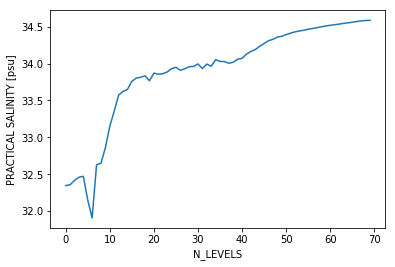

In [26]:
ds[5]['PSAL'][0,].plot()

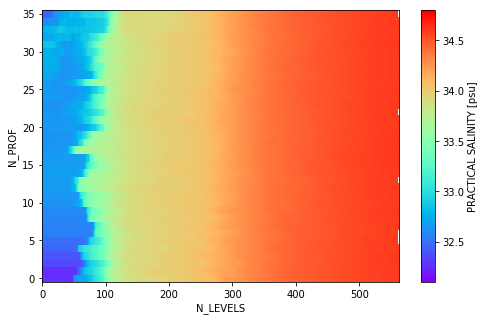

In [27]:
ds[3].PSAL.plot(figsize=(8, 5),cmap=plt.cm.rainbow,vmin=32.1, vmax=34.8)

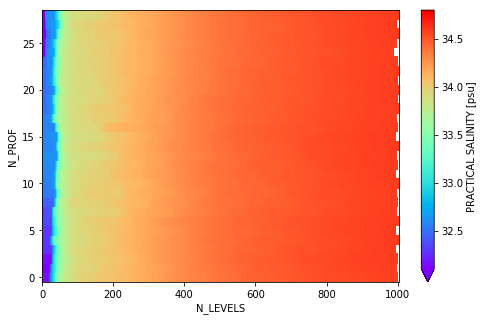

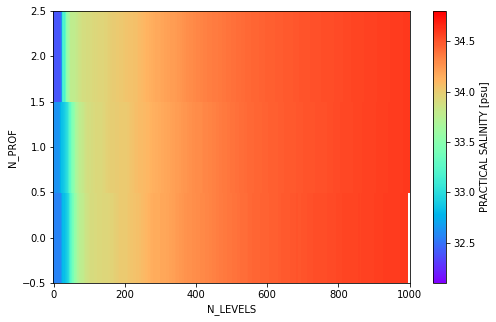

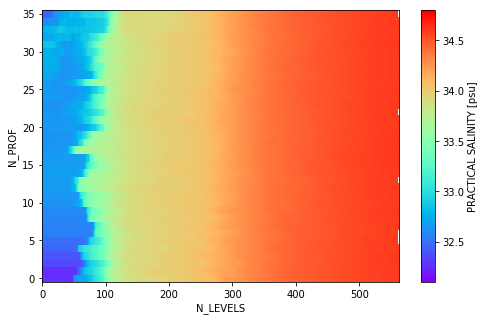

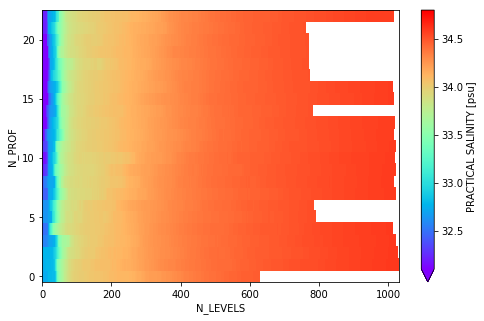

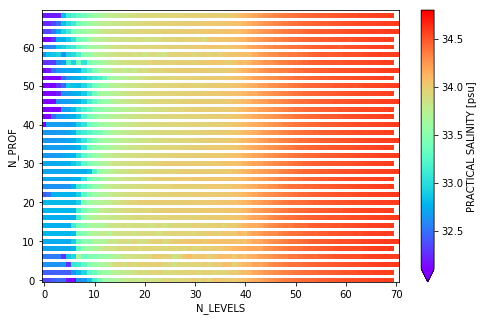

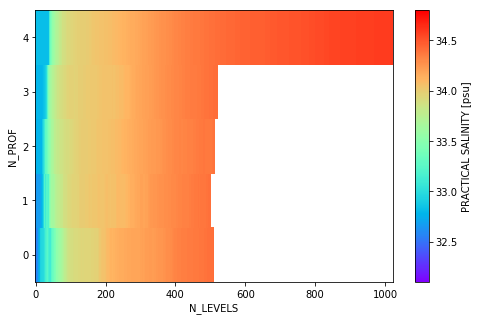

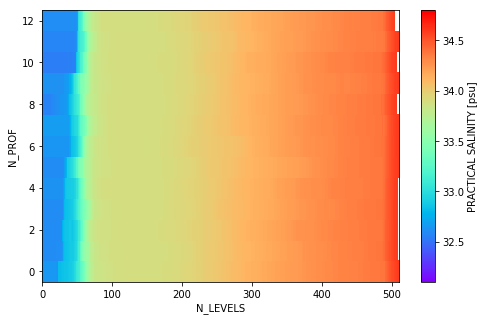

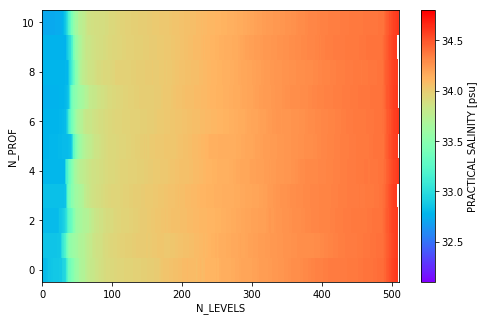

In [28]:
# This is buggy: It does not admit of platform 0 (which was the only one with 1 profile...)
they = []
for i in range(1, 9):
    they.append(ds[i].PSAL.plot(figsize=(8, 5),cmap=plt.cm.rainbow,vmin=32.1, vmax=34.8))

# This starts to tick away at subplots...
# fig, ax = plt.subplots(3, 3, figsize=(15, 15))
# for i in range(3):
    # for j in range(3):
        # index = i*3 + j
        # ax[j, i].plot(ds[index].PSAL) # , cmap=plt.cm.bwr,vmin=32, vmax=35.5)

<xarray.DataArray 'PSAL' (N_PROF: 29, N_LEVELS: 1004)>
dask.array<shape=(29, 1004), dtype=float32, chunksize=(29, 1004)>
Dimensions without coordinates: N_PROF, N_LEVELS
Attributes:
    long_name:       PRACTICAL SALINITY
    standard_name:   sea_water_salinity
    units:           psu
    valid_min:       0.0
    valid_max:       42.0
    C_format:        %9.3f
    FORTRAN_format:  F9.3
    resolution:      0.001


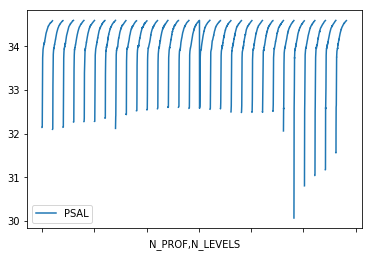

In [29]:
S=ds[1]['PSAL'].to_dataframe()
T=ds[1]['TEMP'].to_dataframe()
P=ds[1]['PRES'].to_dataframe()

SS = ds[1].PSAL
TT = ds[1].TEMP
PP = ds[1].PRES

# print(S) will print N_PROF = 0, N_LEVELS = 0, 1, ..., 396, PSAL values from 32.8 up to 34.6
# S.plot() is the same as SS.plot() but with a little legend included
print(SS)
S.plot()

argo = xr.Dataset(
    data_vars={'salinity':    (('level', 'date'), S),
                'temperature': (('level', 'date'), T),
                'pressure':    (('level', 'date'), P)},
    coords={'level': levels,
             'date': date})
argo

In [30]:
# Compare pressure in decibars to depth in meters
def depth_meters(p, latitude):
    # p = pressure in decibars
    # latitude is in decimal degrees
    x = np.power(np.sin(latitude / 57.29578), 2)
    g = 9.780318 * (1.0 + (5.2788e-3 + 2.36e-5 * x) * x) + 1.092e-6*p
    depth_meters = ((((-1.82e-15*p + 2.279e-10 ) * p - 2.2512e-5 ) * p + 9.72659) * p) / g
    return depth_meters

p = 2006.21
adepth = depth_meters(p, 45.514)
print(adepth)

p = 100.0
adepth = depth_meters(p, 45.514)
print(adepth)

1980.3333696950594
99.15952686423782


CPU times: user 46.9 ms, sys: 68 µs, total: 46.9 ms
Wall time: 124 ms


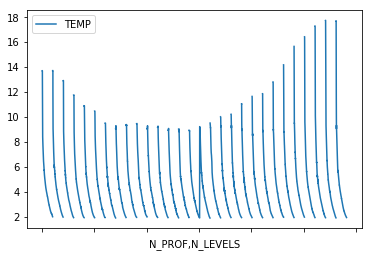

In [31]:
%%time
# plt.close()
# fig,ax = plt.subplots()
# fig.set_size_inches(16,6)
T.plot()

In [32]:
# This is an interesting feature; but I'm not sure how it would be helpful beyond 'ds[0]'
ds[0].keys()

KeysView(<xarray.Dataset>
Dimensions:                       (N_CALIB: 1, N_HISTORY: 9, N_LEVELS: 397, N_PARAM: 3, N_PROF: 1)
Dimensions without coordinates: N_CALIB, N_HISTORY, N_LEVELS, N_PARAM, N_PROF
Data variables:
    DATA_TYPE                     object ...
    FORMAT_VERSION                object ...
    HANDBOOK_VERSION              object ...
    REFERENCE_DATE_TIME           object ...
    DATE_CREATION                 object ...
    DATE_UPDATE                   object ...
    PLATFORM_NUMBER               (N_PROF) object dask.array<shape=(1,), chunksize=(1,)>
    PROJECT_NAME                  (N_PROF) object dask.array<shape=(1,), chunksize=(1,)>
    PI_NAME                       (N_PROF) object dask.array<shape=(1,), chunksize=(1,)>
    STATION_PARAMETERS            (N_PROF, N_PARAM) object dask.array<shape=(1, 3), chunksize=(1, 3)>
    CYCLE_NUMBER                  (N_PROF) float64 dask.array<shape=(1,), chunksize=(1,)>
    DIRECTION                     (N_PROF) object da

### Second: WMS (Web Mapping Service) trial layers

[This page](https://disc.gsfc.nasa.gov/information/tool)
 has some information on Goddard WMSs. It also mentions the [Giovanni]( http://giovanni.gsfc.nasa.gov/giovanni/)
 web application if you are interested in trying that out. It is produced by GES DISC.

In [33]:
# Optional

# This cell is for trying out different WMS layers. The trick is in four parts
#   1. Get the correct URL for the WMS server
#   2. Get the layer correct
#   3. Get the format correct
#   4. Get the style correct
#
# ...and sometimes format and style are not needed. 
#
# wms = WMSLayer(url="http://gmrt.marine-geo.org/cgi-bin/mapserv?map=/public/mgg/web/gmrt.marine-geo.org/htdocs/services/map/wms_merc.map", layers='topo')
# This variant works we well...
# wms = WMSLayer(url='https://www.gmrt.org/cgi-bin/mapserv?map=/gmrt/public/mgg/web/cloud-www.gmrt.org/includes/mapfiles/wms_merc.map&version=1.3.0&service=WMS&request=GetLegendGraphic&sld_version=1.1.0&layer=topo&format=image/png&STYLE=default', layers='topo')
# This was pulled from the GetCapabilities at https://www.gmrt.org/services/mapserver/wms_merc?request=GetCapabilities&service=WMS&version=1.3.0
#   This same file is where you would identify 'topo' as the layers='topo' parameter; and no style parameter.
# 
# wms = WMSLayer(url="http://disc1.gesdisc.eosdis.nasa.gov/daac-bin/wms_airsnrt?service=wms&version=1.1.1&request=getcapabilities")
# wms = WMSLayer(url='https://neo.sci.gsfc.nasa.gov/wms/wms?version=1.1.1&service=WMS&request=GetCapabilities')
# wms = WMSLayer(url="https://neo.sci.gsfc.nasa.gov/servlet/FGDCMetadata?datasetId=AVHRR_CLIM_M", layer='MOP_CO_M', style='gs')  

m = Map(center=(45.5, -127.5), zoom=3, layout=Layout(width='100%', height='900px'))

m.add_layer(wms)

# Toss in the CA location markers
circle_tuple = ()
site_colors = ['red', 'orange', 'yellow', 'green', 'cyan', 'blue', 'violet', 'white']
for i in range(8):
    site = getCASite(i)
    thisCircle = Circle(location=(site[1], site[2]), radius=14, \
                        color=site_colors[i], fill_color=site_colors[i], \
                        title=site[0])
    circle_tuple += (thisCircle,)  
m.add_layer(LayerGroup(layers=circle_tuple))

m

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

In [34]:
dir(wms)

['__class__',
 '__del__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_notifiers',
 '_call_widget_constructed',
 '_comm_changed',
 '_compare',
 '_cross_validation_lock',
 '_default_keys',
 '_default_options',
 '_display_callbacks',
 '_gen_repr_from_keys',
 '_get_embed_state',
 '_handle_custom_msg',
 '_handle_displayed',
 '_handle_leaflet_event',
 '_handle_msg',
 '_holding_sync',
 '_ipython_display_',
 '_is_numpy',
 '_load_callbacks',
 '_lock_property',
 '_log_default',
 '_model_id',
 '_model_module',
 '_model_module_version',
 '_model_name',
 '_msg_callbacks',
 '_notify_trait',
 '_property_lock',
 '_register_validator',
 '_remove_notifiers'

In [35]:
wms.url, wms.layers, wms.styles

('http://gmrt.marine-geo.org/cgi-bin/mapserv?map=/public/mgg/web/gmrt.marine-geo.org/htdocs/services/map/wms_merc.map',
 'topo',
 '')